In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sn
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from tensorflow.keras import layers, callbacks

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading Tranning Dataset

In [130]:
path = "/content/drive/MyDrive/Group_32/PDX_Train.csv"
PDX_Train = pd.read_csv(path)
PDX_Train=PDX_Train.drop('Unnamed: 0',axis=1)

In [ ]:
path = "/content/drive/MyDrive/Group_32/PDY_Train.csv"
PDY_Train = pd.read_csv(path)
PDY_Train=PDY_Train.drop('Unnamed: 0',axis=1)

In [ ]:
PDY_Train

,Label
0,3
1,5
2,3
3,9
4,0
...,...
11380,5
11381,3
11382,5
11383,0


# Reading Testing dataset.

In [ ]:
path = "/content/drive/MyDrive/Group_32/PDX_Test.csv"
PDX_Test = pd.read_csv(path)
PDX_Test=PDX_Test.drop('Unnamed: 0',axis=1)

In [ ]:
path = "/content/drive/MyDrive/Group_32/PDY_Test.csv"
PDY_Test = pd.read_csv(path)
PDY_Test=PDY_Test.drop('Unnamed: 0',axis=1)

In [ ]:
PDY_Test

,Label
0,3
1,9
2,9
3,3
4,5
...,...
3790,3
3791,5
3792,3
3793,6


# Reading Validation Data

In [ ]:
path = "/content/drive/MyDrive/Group_32/PDX_Val.csv"
PDX_Val = pd.read_csv(path)
PDX_Val=PDX_Val.drop('Unnamed: 0',axis=1)

In [ ]:
path = "/content/drive/MyDrive/Group_32/PDY_Val.csv"
PDY_Val = pd.read_csv(path)
PDY_Val=PDY_Val.drop('Unnamed: 0',axis=1)

# Building AutoEncoder

In [ ]:
X_Train=PDX_Train.values
Y_Train=PDY_Train.values

In [ ]:
X_Test=PDX_Test.values
Y_Test=PDY_Test.values

In [ ]:
X_Val=PDX_Val.values
Y_Val=PDY_Val.values

In [ ]:
X_Val.shape

(3795, 784)

In [ ]:
X_Train=X_Train/255
X_Val=X_Val/255
X_Test=X_Test/255

# Autoencoder with One Hidden layer

In [ ]:
autoencoder = Sequential()
autoencoder.add(Dense(50,  activation='sigmoid',name="bottleneck",input_shape=(784,)))
autoencoder.add(Dense(784,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

early_stopping = callbacks.EarlyStopping(
    min_delta=10E-4, # difference between average error of successive epochs fall below a threshold 10-4
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)
#Train Model
trained_model = autoencoder.fit(X_Train, X_Train, batch_size=32, epochs=50, verbose=1, validation_data=(X_Val, X_Val),callbacks=[early_stopping])


encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
Train_encoded_data = encoder.predict(X_Train)  # bottleneck representation
Val_encoded_data = encoder.predict(X_Val)
Test_encoded_data =  encoder.predict(X_Test)
decoded_output = autoencoder.predict(X_Train)        # reconstruction
encoding_dim = 50

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-1](encoded_input)
decoder = Model(encoded_input, decoder)

Epoch 1/50
356/356 [==============================] - 2s 3ms/step - loss: 0.0765 - val_loss: 0.0672
Epoch 2/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0659 - val_loss: 0.0635
Epoch 3/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0590 - val_loss: 0.0548
Epoch 4/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0512 - val_loss: 0.0485
Epoch 5/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0460 - val_loss: 0.0444
Epoch 6/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0425 - val_loss: 0.0413
Epoch 7/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0396 - val_loss: 0.0386
Epoch 8/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0372 - val_loss: 0.0365
Epoch 9/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0352 - val_loss: 0.0347
Epoch 10/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0336 - val_loss: 0.0333

Minimum Validation Loss:- 0.011017887853085995


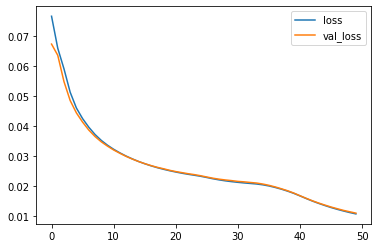

In [ ]:
history_df = pd.DataFrame(trained_model.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
# history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print("Minimum Validation Loss:-",history_df['val_loss'].min())

In [ ]:
decoded_output.shape

(11385, 784)

In [ ]:
Train_encoded_data.shape

(11385, 50)

In [ ]:
autoencoder.evaluate(X_Test, X_Test)

119/119 [==============================] - 0s 2ms/step - loss: 0.0111


0.011063656769692898

In [ ]:
i=decoded_output.reshape(11385,28,28)

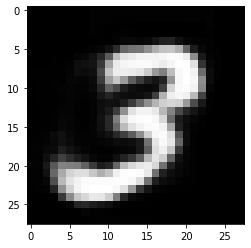

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(i[0],cmap='gray')

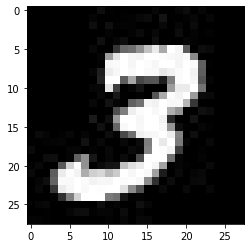

In [ ]:
ti=X_Train.reshape(11385,28,28)
plt.imshow(ti[0],cmap='gray')

# FCNN For Compressed data Classification.

In [ ]:
Train_encoded_data.shape

(11385, 50)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(400, input_shape=(50,), activation='sigmoid'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.Dense(200, activation='sigmoid'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras import layers, callbacks

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=10E-4, # minimium amount of change to count as an improvement
    patience=1, # how many epochs to wait before stopping
    restore_best_weights=True,
)


history = model.fit(
    Train_encoded_data, Y_Train,
    validation_data=(Val_encoded_data, Y_Val),
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
356/356 [==============================] - 2s 5ms/step - loss: 0.9623 - accuracy: 0.6113 - val_loss: 0.4154 - val_accuracy: 0.8627
Epoch 2/100
356/356 [==============================] - 2s 5ms/step - loss: 0.3025 - accuracy: 0.8964 - val_loss: 0.2895 - val_accuracy: 0.9054
Epoch 3/100
356/356 [==============================] - 2s 5ms/step - loss: 0.2500 - accuracy: 0.9135 - val_loss: 0.2480 - val_accuracy: 0.9173
Epoch 4/100
356/356 [==============================] - 2s 5ms/step - loss: 0.2342 - accuracy: 0.9188 - val_loss: 0.2299 - val_accuracy: 0.9225
Epoch 5/100
356/356 [==============================] - 2s 5ms/step - loss: 0.2286 - accuracy: 0.9196 - val_loss: 0.2391 - val_accuracy: 0.9170


Best Validation Loss: 0.2299
Best Validation Accuracy: 0.9225


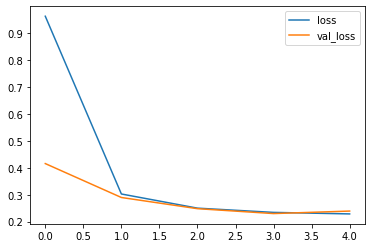

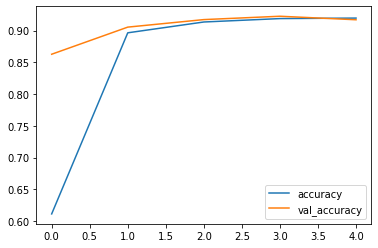

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

In [ ]:
model.evaluate(Test_encoded_data, Y_Test)

119/119 [==============================] - 0s 2ms/step - loss: 0.2210 - accuracy: 0.9246


[0.22097556293010712, 0.9246376752853394]

In [ ]:
y_pred = model.predict(Test_encoded_data)

In [ ]:
pred_out = []
for dataPoint in y_pred:
  pred_out.append(np.argmax(dataPoint))

In [ ]:
y_pred

array([[0.9414071 , 0.00545976, 0.00760168, ..., 0.00437525, 0.02194631,
        0.3429755 ],
       [0.03554195, 0.00904074, 0.00466385, ..., 0.00513467, 0.03139323,
        0.9984792 ],
       [0.04661971, 0.01273841, 0.00367737, ..., 0.00416353, 0.0416787 ,
        0.9996506 ],
       ...,
       [0.68982214, 0.00356805, 0.00449872, ..., 0.00504473, 0.01352847,
        0.55278563],
       [0.77019763, 0.01243222, 0.00633398, ..., 0.00713041, 0.01512229,
        0.31316936],
       [0.9847292 , 0.00918466, 0.00462246, ..., 0.00684667, 0.02783707,
        0.93259525]], dtype=float32)

In [ ]:
cm = tf.math.confusion_matrix(labels=Y_Test,predictions=pred_out)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[735,   0,   0,   2,   0,  10,   6,   0,   0,   6],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 19,   0,   0, 669,   0,  50,   4,   0,   0,  17],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 21,   0,   0,  50,   0, 657,  21,   0,   0,  10],
       [ 10,   0,   0,   5,   0,  17, 724,   0,   0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  9,   0,   0,  21,   0,   5,   0,   0,   0, 724]], dtype=int32)>

Text(69.0, 0.5, 'Truth')

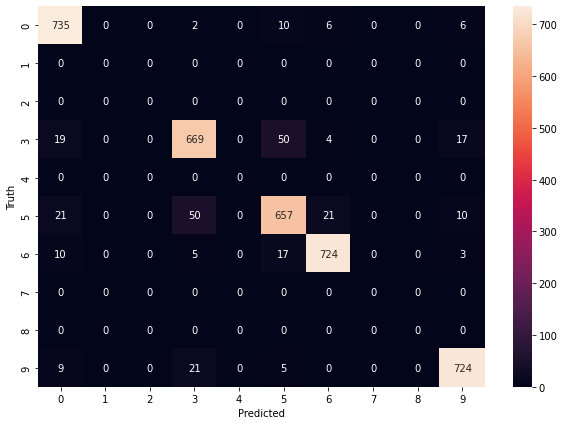

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# **Autoencoder with 3 hidden Layer.**

In [ ]:
autoencoder = Sequential()
autoencoder.add(Dense(300,  activation='sigmoid', input_shape=(784,)))
autoencoder.add(Dense(50,    activation='sigmoid', name="bottleneck"))
autoencoder.add(Dense(300,  activation='sigmoid'))
autoencoder.add(Dense(784,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

early_stopping = callbacks.EarlyStopping(
    min_delta=10E-4, # difference between average error of successive epochs fall below a threshold 10-4
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)
trained_model = autoencoder.fit(X_Train, X_Train, batch_size=32, epochs=50, verbose=1, validation_data=(X_Val, X_Val),callbacks=[early_stopping])


encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
Train_encoded_data = encoder.predict(X_Train)  # bottleneck representation
Val_encoded_data = encoder.predict(X_Val)
Test_encoded_data =  encoder.predict(X_Test)
decoded_output = autoencoder.predict(X_Train)        # reconstruction
encoding_dim = 50

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-2](encoded_input)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

Epoch 1/50
356/356 [==============================] - 3s 8ms/step - loss: 0.0651 - val_loss: 0.0537
Epoch 2/50
356/356 [==============================] - 3s 7ms/step - loss: 0.0463 - val_loss: 0.0418
Epoch 3/50
356/356 [==============================] - 3s 8ms/step - loss: 0.0390 - val_loss: 0.0373
Epoch 4/50
356/356 [==============================] - 3s 9ms/step - loss: 0.0347 - val_loss: 0.0330
Epoch 5/50
356/356 [==============================] - 3s 8ms/step - loss: 0.0310 - val_loss: 0.0295
Epoch 6/50
356/356 [==============================] - 3s 7ms/step - loss: 0.0279 - val_loss: 0.0267
Epoch 7/50
356/356 [==============================] - 3s 7ms/step - loss: 0.0253 - val_loss: 0.0243
Epoch 8/50
356/356 [==============================] - 2s 7ms/step - loss: 0.0232 - val_loss: 0.0225
Epoch 9/50
356/356 [==============================] - 3s 8ms/step - loss: 0.0214 - val_loss: 0.0209
Epoch 10/50
356/356 [==============================] - 3s 9ms/step - loss: 0.0199 - val_loss: 0.0195

Minimum Validation Loss:- 0.01049319002777338


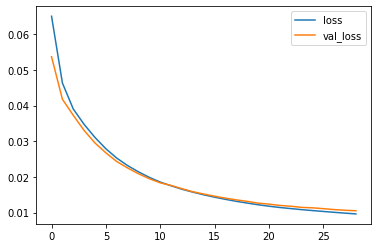

In [ ]:
history_df = pd.DataFrame(trained_model.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
# history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print("Minimum Validation Loss:-",history_df['val_loss'].min())

In [ ]:
i=decoded_output.reshape(11385,28,28)

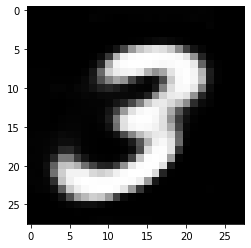

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(i[0],cmap='gray')

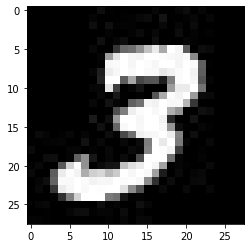

In [ ]:
ti=X_Train.reshape(11385,28,28)
plt.imshow(ti[0],cmap='gray')

# FCNN For Compressed data Classification.

In [ ]:
Train_encoded_data.shape

(11385, 50)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(400, input_shape=(50,), activation='sigmoid'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.Dense(200, activation='sigmoid'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras import layers, callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=10E-4, # minimium amount of change to count as an improvement
    patience=1, # how many epochs to wait before stopping
    restore_best_weights=True,
)


history = model.fit(
    Train_encoded_data, Y_Train,
    validation_data=(Val_encoded_data, Y_Val),
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
356/356 [==============================] - 14s 6ms/step - loss: 0.9076 - accuracy: 0.6314 - val_loss: 0.3847 - val_accuracy: 0.8801
Epoch 2/100
356/356 [==============================] - 2s 5ms/step - loss: 0.2805 - accuracy: 0.9069 - val_loss: 0.2897 - val_accuracy: 0.9028
Epoch 3/100
356/356 [==============================] - 2s 5ms/step - loss: 0.2502 - accuracy: 0.9132 - val_loss: 0.2482 - val_accuracy: 0.9157
Epoch 4/100
356/356 [==============================] - 2s 4ms/step - loss: 0.2326 - accuracy: 0.9225 - val_loss: 0.2565 - val_accuracy: 0.9133


Best Validation Loss: 0.2482
Best Validation Accuracy: 0.9157


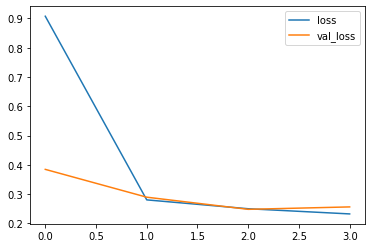

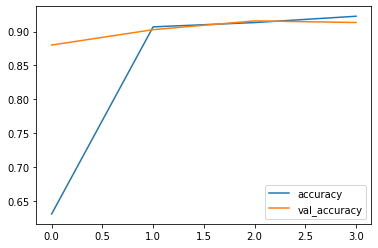

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

In [ ]:
model.evaluate(Test_encoded_data, Y_Test)

119/119 [==============================] - 0s 2ms/step - loss: 0.2368 - accuracy: 0.9207


[0.23684906959533691, 0.9206851124763489]

In [ ]:
y_pred = model.predict(Test_encoded_data)

In [ ]:
pred_out = []
for dataPoint in y_pred:
  pred_out.append(np.argmax(dataPoint))

In [ ]:
y_pred

array([[0.964736  , 0.0115141 , 0.00531128, ..., 0.01545864, 0.0042007 ,
        0.2127367 ],
       [0.04968616, 0.00661924, 0.00482544, ..., 0.0097675 , 0.00718996,
        0.9970619 ],
       [0.06715384, 0.00617328, 0.00565928, ..., 0.01435319, 0.00580367,
        0.9992162 ],
       ...,
       [0.738583  , 0.01025027, 0.0048328 , ..., 0.00907144, 0.00616518,
        0.3708657 ],
       [0.72883594, 0.01055765, 0.00653785, ..., 0.01689881, 0.00402227,
        0.17091578],
       [0.99263215, 0.01072493, 0.00744033, ..., 0.01410455, 0.0039781 ,
        0.4506919 ]], dtype=float32)

In [ ]:
cm = tf.math.confusion_matrix(labels=Y_Test,predictions=pred_out)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[740,   0,   0,   2,   0,   7,   7,   0,   0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 14,   0,   0, 690,   0,  44,   5,   0,   0,   6],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 25,   0,   0,  57,   0, 657,  18,   0,   0,   2],
       [ 10,   0,   0,   9,   0,  18, 722,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 17,   0,   0,  38,   0,  19,   0,   0,   0, 685]], dtype=int32)>

Text(69.0, 0.5, 'Actual')

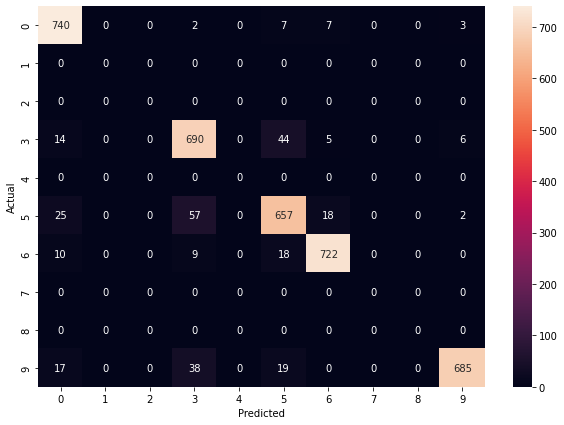

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# B. Denoising Autoencoder

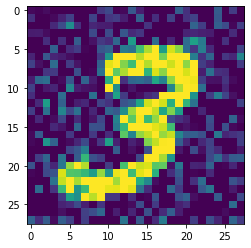

In [ ]:
noise_factor = 0.2
X_Train_noisy = X_Train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_Train.shape) 
X_Test_noisy = X_Test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_Test.shape)
X_Val_noisy = X_Val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_Val.shape)

X_Train_noisy = np.clip(X_Train_noisy, 0., 1.)
X_Test_noisy = np.clip(X_Test_noisy, 0., 1.)
X_Val_noisy = np.clip(X_Val_noisy, 0., 1.)

#Print one image to see the noise
plt.imshow(X_Train_noisy[0].reshape(28, 28))

In [ ]:
X_Val_noisy.shape

(3795, 784)

In [ ]:
autoencoder = Sequential()
autoencoder.add(Dense(50,  activation='sigmoid',name="bottleneck",input_shape=(784,)))
autoencoder.add(Dense(784,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

early_stopping = callbacks.EarlyStopping(
    min_delta=10E-4, # difference between average error of successive epochs fall below a threshold 10-4
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)
#Train Model
trained_model = autoencoder.fit(X_Train_noisy, X_Train_noisy, batch_size=32, epochs=50, verbose=1, validation_data=(X_Val_noisy , X_Val_noisy ),callbacks=[early_stopping])


encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
Train_encoded_data = encoder.predict(X_Train_noisy)  # bottleneck representation
Val_encoded_data = encoder.predict(X_Val_noisy )
Test_encoded_data =  encoder.predict(X_Test)
decoded_output = autoencoder.predict(X_Train_noisy)        # reconstruction
encoding_dim = 50

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-1](encoded_input)
decoder = Model(encoded_input, decoder)

Epoch 1/50
356/356 [==============================] - 2s 4ms/step - loss: 0.0703 - val_loss: 0.0646
Epoch 2/50
356/356 [==============================] - 1s 4ms/step - loss: 0.0620 - val_loss: 0.0592
Epoch 3/50
356/356 [==============================] - 2s 4ms/step - loss: 0.0564 - val_loss: 0.0541
Epoch 4/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0522 - val_loss: 0.0506
Epoch 5/50
356/356 [==============================] - 1s 4ms/step - loss: 0.0491 - val_loss: 0.0480
Epoch 6/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0467 - val_loss: 0.0460
Epoch 7/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0448 - val_loss: 0.0442
Epoch 8/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0431 - val_loss: 0.0426
Epoch 9/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0415 - val_loss: 0.0409
Epoch 10/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0396 - val_loss: 0.0390

In [ ]:
Train_encoded_data.shape

(11385, 50)

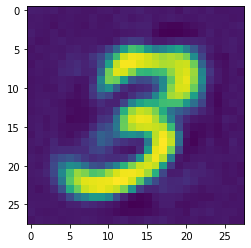

In [ ]:
plt.imshow(decoded_output[0].reshape(28,28))

In [ ]:
X_Val.shape

(3795, 784)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(400, input_shape=(50,), activation='sigmoid'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.Dense(200, activation='sigmoid'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras import layers, callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=10E-4, # minimium amount of change to count as an improvement
    patience=1, # how many epochs to wait before stopping
    restore_best_weights=True,
)


history = model.fit(
    Train_encoded_data, Y_Train,
    validation_data=(Val_encoded_data, Y_Val),
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
356/356 [==============================] - 2s 5ms/step - loss: 1.1725 - accuracy: 0.5080 - val_loss: 0.4193 - val_accuracy: 0.8796
Epoch 2/100
356/356 [==============================] - 2s 5ms/step - loss: 0.2940 - accuracy: 0.9068 - val_loss: 0.2582 - val_accuracy: 0.9144
Epoch 3/100
356/356 [==============================] - 2s 5ms/step - loss: 0.2403 - accuracy: 0.9194 - val_loss: 0.2464 - val_accuracy: 0.9167
Epoch 4/100
356/356 [==============================] - 2s 4ms/step - loss: 0.2249 - accuracy: 0.9225 - val_loss: 0.2359 - val_accuracy: 0.9202
Epoch 5/100
356/356 [==============================] - 3s 7ms/step - loss: 0.2221 - accuracy: 0.9231 - val_loss: 0.2181 - val_accuracy: 0.9236
Epoch 6/100
356/356 [==============================] - 2s 4ms/step - loss: 0.2168 - accuracy: 0.9267 - val_loss: 0.2466 - val_accuracy: 0.9183


Best Validation Loss: 0.2181
Best Validation Accuracy: 0.9236


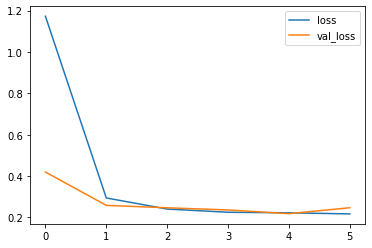

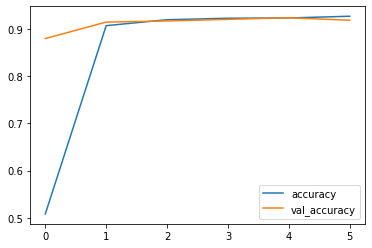

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

In [ ]:
model.evaluate(Test_encoded_data, Y_Test)

119/119 [==============================] - 0s 2ms/step - loss: 0.1985 - accuracy: 0.9394


[0.19854658842086792, 0.939393937587738]

In [ ]:
y_pred = model.predict(Test_encoded_data)

In [ ]:
pred_out = []
for dataPoint in y_pred:
  pred_out.append(np.argmax(dataPoint))

In [ ]:
y_pred

array([[0.8173108 , 0.00641963, 0.00581396, ..., 0.00617272, 0.0058212 ,
        0.3374779 ],
       [0.00387836, 0.00561434, 0.00490585, ..., 0.00458136, 0.00278315,
        0.9979049 ],
       [0.0030199 , 0.00491229, 0.00422442, ..., 0.00427926, 0.00383121,
        0.9997864 ],
       ...,
       [0.69457865, 0.00513032, 0.00391424, ..., 0.00325513, 0.00314561,
        0.8287381 ],
       [0.6396631 , 0.00797096, 0.0040215 , ..., 0.00154686, 0.00502187,
        0.1836218 ],
       [0.9965647 , 0.00781038, 0.00419089, ..., 0.00187781, 0.00867125,
        0.81216013]], dtype=float32)

In [ ]:
cm = tf.math.confusion_matrix(labels=Y_Test,predictions=pred_out)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[745,   0,   0,   3,   0,   4,   5,   0,   0,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  7,   0,   0, 680,   0,  50,   6,   0,   0,  16],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 17,   0,   0,  28,   0, 692,  16,   0,   0,   6],
       [  7,   0,   0,   1,   0,  15, 736,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 15,   0,   0,  19,   0,  11,   2,   0,   0, 712]], dtype=int32)>

Text(69.0, 0.5, 'Actual')

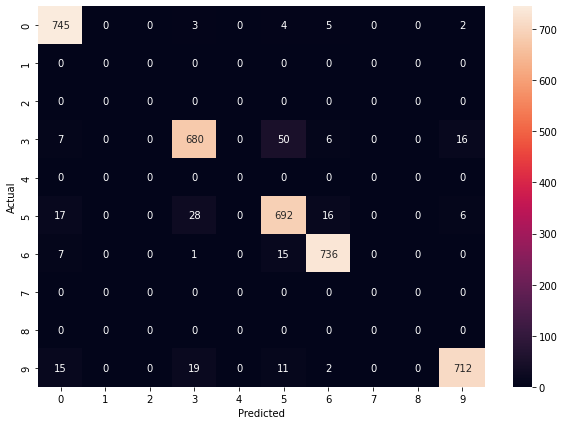

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Denoising For 40%

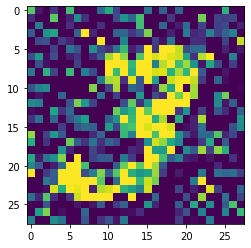

In [ ]:
noise_factor = 0.4
X_Train_noisy = X_Train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_Train.shape) 
X_Test_noisy = X_Test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_Test.shape)
X_Val_noisy = X_Val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_Val.shape)

X_Train_noisy = np.clip(X_Train_noisy, 0., 1.)
X_Test_noisy = np.clip(X_Test_noisy, 0., 1.)
X_Val_noisy = np.clip(X_Val_noisy, 0., 1.)

#Print one image to see the noise
plt.imshow(X_Train_noisy[0].reshape(28, 28))

In [ ]:
X_Val_noisy.shape

(3795, 784)

In [ ]:
autoencoder = Sequential()
autoencoder.add(Dense(50,  activation='sigmoid',name="bottleneck",input_shape=(784,)))
autoencoder.add(Dense(784,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam')

early_stopping = callbacks.EarlyStopping(
    min_delta=10E-4, # difference between average error of successive epochs fall below a threshold 10-4
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)
#Train Model
trained_model = autoencoder.fit(X_Train_noisy, X_Train_noisy, batch_size=32, epochs=50, verbose=1, validation_data=(X_Val_noisy , X_Val_noisy ),callbacks=[early_stopping])


encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
Train_encoded_data = encoder.predict(X_Train_noisy)  # bottleneck representation
Val_encoded_data = encoder.predict(X_Val_noisy )
Test_encoded_data =  encoder.predict(X_Test)
decoded_output = autoencoder.predict(X_Train_noisy)        # reconstruction
encoding_dim = 50

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-1](encoded_input)
decoder = Model(encoded_input, decoder)

Epoch 1/50
356/356 [==============================] - 2s 3ms/step - loss: 0.0926 - val_loss: 0.0893
Epoch 2/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0869 - val_loss: 0.0841
Epoch 3/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0820 - val_loss: 0.0803
Epoch 4/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0792 - val_loss: 0.0782
Epoch 5/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0773 - val_loss: 0.0765
Epoch 6/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0756 - val_loss: 0.0750
Epoch 7/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0742 - val_loss: 0.0737
Epoch 8/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0730 - val_loss: 0.0727
Epoch 9/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0721 - val_loss: 0.0719
Epoch 10/50
356/356 [==============================] - 1s 3ms/step - loss: 0.0713 - val_loss: 0.0712

In [ ]:
Train_encoded_data.shape

(11385, 50)

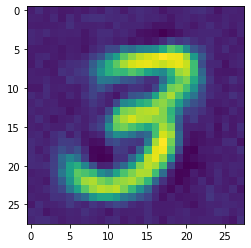

In [ ]:
plt.imshow(decoded_output[0].reshape(28,28))

In [ ]:
X_Val.shape

(3795, 784)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(400, input_shape=(50,), activation='sigmoid'),
    keras.layers.Dense(300, activation='sigmoid'),
    keras.layers.Dense(200, activation='sigmoid'),
    keras.layers.Dense(10, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras import layers, callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=10E-4, # minimium amount of change to count as an improvement
    patience=1, # how many epochs to wait before stopping
    restore_best_weights=True,
)


history = model.fit(
    Train_encoded_data, Y_Train,
    validation_data=(Val_encoded_data, Y_Val),
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
356/356 [==============================] - 2s 5ms/step - loss: 1.2418 - accuracy: 0.4721 - val_loss: 0.5273 - val_accuracy: 0.8248
Epoch 2/100
356/356 [==============================] - 2s 5ms/step - loss: 0.3890 - accuracy: 0.8682 - val_loss: 0.3667 - val_accuracy: 0.8725
Epoch 3/100
356/356 [==============================] - 2s 5ms/step - loss: 0.3240 - accuracy: 0.8910 - val_loss: 0.3279 - val_accuracy: 0.8885
Epoch 4/100
356/356 [==============================] - 2s 5ms/step - loss: 0.3128 - accuracy: 0.8934 - val_loss: 0.3372 - val_accuracy: 0.8877


Best Validation Loss: 0.3279
Best Validation Accuracy: 0.8885


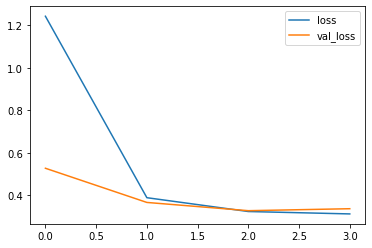

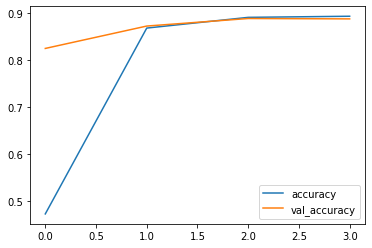

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))

In [ ]:
model.evaluate(Test_encoded_data, Y_Test)

119/119 [==============================] - 0s 2ms/step - loss: 0.3414 - accuracy: 0.8809


[0.3414396345615387, 0.8808959126472473]

In [ ]:
y_pred = model.predict(Test_encoded_data)

In [ ]:
pred_out = []
for dataPoint in y_pred:
  pred_out.append(np.argmax(dataPoint))

In [ ]:
y_pred

array([[0.92118573, 0.01011527, 0.00274792, ..., 0.00712344, 0.00937387,
        0.31857276],
       [0.02140102, 0.01267686, 0.00840172, ..., 0.0063504 , 0.0184482 ,
        0.99912447],
       [0.03695697, 0.01462117, 0.00944418, ..., 0.00613323, 0.01740643,
        0.9994854 ],
       ...,
       [0.6078056 , 0.00882465, 0.00313351, ..., 0.00817513, 0.01437777,
        0.6346834 ],
       [0.45324847, 0.01629728, 0.00966087, ..., 0.00792456, 0.01526305,
        0.43718055],
       [0.99918485, 0.01677218, 0.00521156, ..., 0.00992772, 0.01938063,
        0.41757575]], dtype=float32)

In [ ]:
cm = tf.math.confusion_matrix(labels=Y_Test,predictions=pred_out)
cm

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[749,   0,   0,   2,   0,   2,   3,   0,   0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 32,   0,   0, 681,   0,  23,   5,   0,   0,  18],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [112,   0,   0,  92,   0, 518,  24,   0,   0,  13],
       [ 31,   0,   0,   4,   0,  16, 707,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 28,   0,   0,  28,   0,   9,   6,   0,   0, 688]], dtype=int32)>

Text(69.0, 0.5, 'Actual')

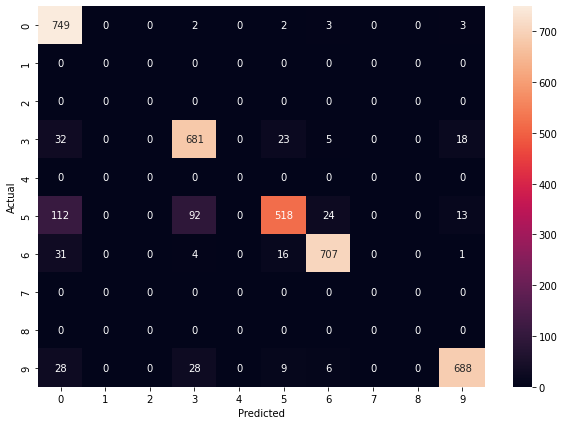

In [ ]:
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')